## Median Nerve Stimulation Data Set

In [53]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../')
import numpy as np

import mne
from mne.datasets.brainstorm import bst_raw
from mne.io import read_raw_ctf
import tensorflow as tf

from esinet import forward
from esinet import util
from esinet import net
from esinet import simulation

plot_params = dict(surface='white', hemi='both', verbose=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

ds directory : C:\Users\lukas\mne_data\MNE-brainstorm-data\bst_raw\MEG\bst_raw\subj001_somatosensory_20111109_01_AUX-f.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.84   69.49    0.00 mm <->    0.84   69.49   -0.00 mm (orig :  -44.30   51.45 -252.43 mm) diff =    0.000 mm
      -0.84  -69.49    0.00 mm <->   -0.84  -69.49   -0.00 mm (orig :   46.28  -53.58 -243.47 mm) diff =    0.000 mm
      86.41    0.00    0.00 mm <->   86.41    0.00    0.00 mm (orig :   63.60   55.82 -230.26 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['C:\\Users\\lukas\\mne_data\\MNE-brainstorm-data\\bst_raw\\MEG\\bst_raw\\subj001_somatosensory_20111109_01_AUX-f.ds\\subj00111092011.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 2 EEG channels from channel info
    2 EEG locations a

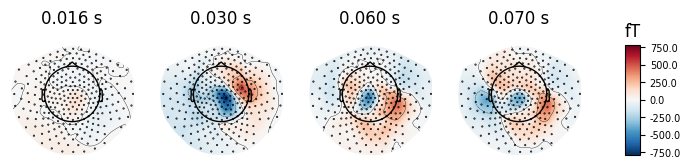

Channels marked as bad: none


In [71]:

tmin, tmax, event_id = -0.1, 0.3, 2  # take right-hand somato
reject = dict(mag=4e-12, eog=250e-6)

data_path = bst_raw.data_path()

raw_path = (data_path + '/MEG/bst_raw/' +
            'subj001_somatosensory_20111109_01_AUX-f.ds')
# Here we crop to half the length to save memory
raw = read_raw_ctf(raw_path).crop(0, 180).load_data()
raw.plot()

# set EOG channel
raw.set_channel_types({'EEG058': 'eog'})
raw.set_eeg_reference('average', projection=True)

# show power line interference and remove it
raw.plot_psd(tmax=60., average=False)
raw.notch_filter(np.arange(60, 181, 60), fir_design='firwin')

events = mne.find_events(raw, stim_channel='UPPT001')

# pick MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')

# Compute epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=False)

# compute evoked
evoked = epochs.average()

# remove physiological artifacts (eyeblinks, heartbeats) using SSP on baseline
evoked.add_proj(mne.compute_proj_evoked(evoked.copy().crop(tmax=0)))
evoked.apply_proj()

# fix stim artifact
mne.preprocessing.fix_stim_artifact(evoked)

# correct delays due to hardware (stim artifact is at 4 ms)
evoked.shift_time(-0.004)

# plot the result
evoked.plot(time_unit='s')

# show topomaps
evoked.plot_topomap(times=np.array([0.016, 0.030, 0.060, 0.070]),
                    time_unit='s')

## Make Forward Model

In [8]:
info = evoked.info
fwd = forward.create_forward_model(info=info)
fwd_free = forward.create_forward_model(info=info, fixed_ori=False)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.3s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

# Inverse Solutions

## ANNs

### Simulate Data

In [82]:
sim = simulation.Simulation(fwd, evoked.info).simulate(n_samples=32)
sim.save(f'simulations/sim_median_nerve_stimulation.pkl')

Simulating data based on sparse patches.


100%|██████████| 32/32 [00:00<00:00, 221.89it/s]


source data shape:  (1284, 1200) (1284, 1200)


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


### Train Models

In [83]:
train_params = dict(epochs=1, patience=2, loss=tf.keras.losses.CosineSimilarity(), 
    optimizer=tf.keras.optimizers.Adam() , return_history=True, 
    metrics=[tf.keras.losses.mean_squared_error], batch_size=8,
    validation_freq=2, validation_split=0.2,
    device=None)

model_params = {
    "Dense Medium": dict(n_dense_layers=2, n_dense_units=300, n_lstm_layers=0),
    "LSTM Medium": dict(n_lstm_layers=2, n_lstm_units=85, n_dense_layers=0),
    "ConvDip Medium": dict(n_lstm_layers=2, n_dense_layers=3, n_dense_units=250, model_type='convdip')
}
for model_name, model_param in model_params.items():
    model = net.Net(fwd, **model_param).fit(sim, **train_params)[0]
    model.model.compile(optimizer='adam', loss='mean_squared_error')
    model.save(r'models', name=f'{model_name}_median_nerve_stimulation')
    del model

preprocess data
Model: "LSTM_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FC_0 (TimeDistributed)       (None, None, 300)         81900     
_________________________________________________________________
Drop_0 (Dropout)             (None, None, 300)         0         
_________________________________________________________________
FC_1 (TimeDistributed)       (None, None, 300)         90300     
_________________________________________________________________
Drop_1 (Dropout)             (None, None, 300)         0         
_________________________________________________________________
FC_Out (TimeDistributed)     (None, None, 1284)        386484    
Total params: 558,684
Trainable params: 558,684
Non-trainable params: 0
_________________________________________________________________
fit model
start generator
3/3 [==============================] - 2s 410ms/step - loss: -0.0050 - mean_s

INFO:tensorflow:Assets written to: models\Dense Medium_median_nerve_stimulation_1\assets


INFO:tensorflow:Assets written to: models\Dense Medium_median_nerve_stimulation_1\assets


preprocess data
Model: "LSTM_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_0 (Bidirectional)        (None, None, 170)         243440    
_________________________________________________________________
Dropout_0 (Dropout)          (None, None, 170)         0         
_________________________________________________________________
RNN_1 (Bidirectional)        (None, None, 170)         174080    
_________________________________________________________________
Dropout_1 (Dropout)          (None, None, 170)         0         
_________________________________________________________________
FC_Out (TimeDistributed)     (None, None, 1284)        219564    
Total params: 637,084
Trainable params: 637,084
Non-trainable params: 0
_________________________________________________________________
fit model
start generator
3/3 [==============================] - 12s 2s/step - loss: -0.0011 - mean_squ

INFO:tensorflow:Assets written to: models\LSTM Medium_median_nerve_stimulation_1\assets


INFO:tensorflow:Assets written to: models\LSTM Medium_median_nerve_stimulation_1\assets


preprocess data
Model: "ConvDip-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 7, 7, 8)     80        
_________________________________________________________________
Drop_conv2d_0 (Dropout)      (None, None, 7, 7, 8)     0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 5, 5, 8)     584       
_________________________________________________________________
Drop_conv2d_1 (Dropout)      (None, None, 5, 5, 8)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 200)         0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 250)         50250     
_________________________________________________________________
Drop_FC_0 (Dropout)          (None, N

INFO:tensorflow:Assets written to: models\ConvDip Medium_median_nerve_stimulation_0\assets


INFO:tensorflow:Assets written to: models\ConvDip Medium_median_nerve_stimulation_0\assets


### Load Models

In [85]:
lstm_standard = util.load_net('models/LSTM Medium_median_nerve_stimulation_0')
dense_standard = util.load_net('models/Dense Medium_median_nerve_stimulation_0')
convdip_standard = util.load_net('models/ConvDip Medium_median_nerve_stimulation_0')

models = [lstm_standard, dense_standard, convdip_standard]
model_names = ['LSTM', 'Fully-Connected', 'ConvDip']

### Predict and Plot

In [86]:
for model, model_name in zip(models, model_names):
    brain = model.predict(evoked)[0].plot(**plot_params)
    brain.add_text(0.1, 0.9, model_name, 'title')

Removing 5 compensators from info because not all compensation channels were picked.
interpolating for convdip...


1it [00:01,  1.23s/it]


Using control points [2.74719199e-09 3.02415909e-09 4.92498674e-09]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [2.56982926e-09 2.87640047e-09 4.64294452e-09]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [5.96347679e-09 6.64647594e-09 1.05943807e-08]


## Classical Inverse Solutions

In [34]:
methods = ["eLORETA", "MNE", "LCMV"]
stcs = {method: util.mne_inverse(fwd, evoked, method=method) for method in methods}

for method, stc in stcs.items():
    brain = stc.plot(**plot_params)
    brain.add_text(0.1, 0.9, method, 'title')

c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:458: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (0.000166667 sec)
  method=method, return_residual=False, verbose=verbose)
c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:458: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (0.000166667 sec)
  method=method, return_residual=False, verbose=verbose)
c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:428: RuntimeWarning: Too few samples (required : 1365 got : 240), covariance estimate may be unreliable
  data_cov = mne.compute_raw_covariance(raw, tmin=tmin,
c:\Users\lukas\Dokumente\projects\esinet\evaluate\..\esinet\util\util.py:445: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (0.000166667 sec)
  stc = mne.beamformer.apply_lcmv(evoked.crop(tmin=0.), lcmv_filter,
